In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import random

## Get the data!

With the help of api.octane.gg I was able to extract
 - How many goals each team has scored
 - How many wins each team has
 - The length of the series (best of 5, 7, 9...)
 - Whether blue team won the series in the end

In [249]:
path_to_data = "./data/rawData.csv"
data = pd.read_csv(path_to_data)

data

,match_url,blue_goals,orange_goals,blue_wins,orange_wins,best_of,did_blue_win,head2head
0,2040105,0,1,0,1,7,False,0.0
1,2040105,3,5,0,2,7,False,0.0
2,2040105,4,7,0,3,7,False,0.0
3,2040105,7,9,1,3,7,False,0.0
4,2040105,12,9,2,3,7,False,0.0
...,...,...,...,...,...,...,...,...
6644,1170114,12,17,1,3,5,False,-0.5
6645,1170113,1,2,0,1,5,True,0.0
6646,1170113,4,2,1,1,5,True,0.0
6647,1170113,9,3,2,1,5,True,0.0


In [250]:
goalDiff = np.array(data.count(axis="columns"))
winDiff = np.array(data.count(axis="columns"))
wonSeries = np.array(data.count(axis="columns"))
head2head = np.array(data.count(axis="columns"))

for i,row in data.iterrows():
    goalDiff[i] = row.blue_goals - row.orange_goals
    winDiff[i] = (row.blue_wins - row.orange_wins) / round(row.best_of/2)
    wonSeries[i] = row.did_blue_win
    head2head[i] = row.head2head # the average of wins in previous matches betweem the two teams

In [337]:
data = list(zip(goalDiff, winDiff))
bins = list(list())

i = bins[:].index(data[0])
if (i == -1):
    bins.append(list(data[0],1))
else:
    bins[i]

data[0]

ValueError: (-1, 0) is not in list

## Let's visualize!

Blue dots means that the blue team won and orange dots means the orange team won.

In [251]:
colors = np.where(wonSeries, "blue", "orange")

Text(0.5, 0, 'Head to Head')

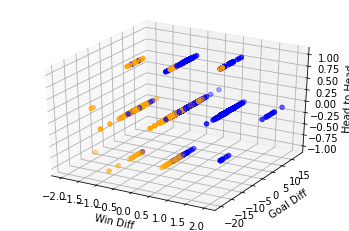

In [272]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(winDiff, goalDiff, head2head, c=colors)
ax.set_xlabel('Win Diff')
ax.set_ylabel('Goal Diff')
ax.set_zlabel('Head to Head')

## Density of Data
That doesn't look like over 6,000 dots. How dense is this data? Let's use a 2D histogram to visualize how many points are at each location.

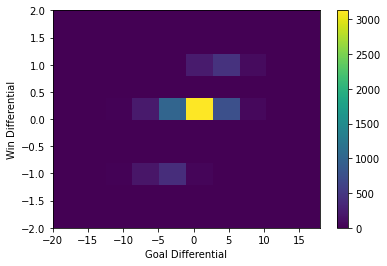

In [276]:
plt.hist2d(x=goalDiff, y=winDiff)
plt.colorbar()
plt.xlabel("Goal Differential")
plt.ylabel("Win Differential")
plt.show()

## Splitting the data

We first combine the our two inputs, goal differential and win differential into a 2D list.

Then we can seperate our data into training and test data. Won series is our actual values.

In [277]:
data_as_list = list(zip(goalDiff, winDiff, head2head))
X_train, X_test, y_train, y_test = train_test_split(
    data_as_list, wonSeries, test_size=0.35, shuffle=True
)

In [7]:
len(X_train), len(X_test)

(4321, 2328)

## C-Support Vector Machine

Make sure we set probablity to true so we get a percentage during prediction. Then, let's fit our training data.

In [130]:
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### So how did it do?

In [134]:
clf.score(X_test, y_test)

0.7457044673539519

### Example sample

In [131]:
i = random.choice(range(len(X_test)))
print("Tested values:")
print("Goal Differential: ", X_test[i][0])
print("Win Differential: ", X_test[i][1])
print("Head to head: ", X_test[i][2])
print("Expected value: ", y_test[i])
print("Blue Win Probability: ", clf.predict_proba([X_test[i][:]])[0][1])

Tested values:
Goal Differential:  0
Win Differential:  0
Head to head:  0
Expected value:  1
Blue Win Probability:  0.6465847593075109


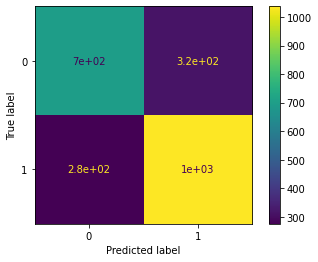

In [133]:
disp = plot_confusion_matrix(clf, X_test, y_test)

## Stochastic Gradient Descent

In [135]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss="hinge", penalty="elasticnet", max_iter=1000)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [136]:
sgd_clf.score(X_test, y_test)

0.7444158075601375

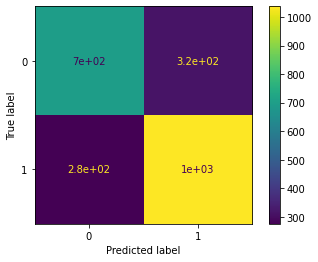

In [137]:
disp = plot_confusion_matrix(clf, X_test, y_test)

## Linear Discriminant Analysis

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf_lda = LinearDiscriminantAnalysis(solver="lsqr")
clf_lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='lsqr', store_covariance=False, tol=0.0001)

In [139]:
clf_lda.score(X_test, y_test)

0.7439862542955327

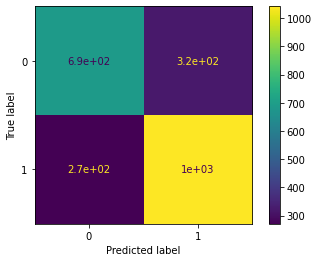

In [140]:
disp = plot_confusion_matrix(clf_lda, X_test, y_test)

## K Nearest Neighbors

In [146]:
from sklearn.neighbors import KNeighborsClassifier
clf_k = KNeighborsClassifier()
clf_k.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [147]:
clf_k.score(X_test, y_test)

0.7074742268041238

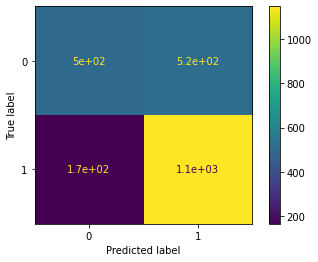

In [148]:
disp = plot_confusion_matrix(clf_k, X_test, y_test)

Yikes

## SGD Classifier

In [149]:
from sklearn.linear_model import SGDClassifier
clf_sgd = SGDClassifier(
    loss="hinge", 
    max_iter=1000, 
    tol=1e-3, 
    learning_rate="adaptive", 
    eta0=0.002, 
    early_stopping=True
)
clf_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.002, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [150]:
clf_sgd.score(X_test, y_test)

0.7444158075601375

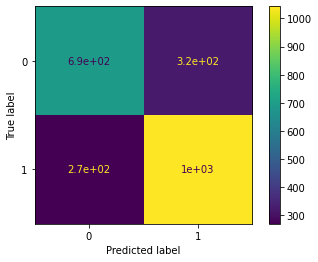

In [151]:
disp = plot_confusion_matrix(clf_sgd, X_test, y_test)

## Random Forest

In [297]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=5)

In [298]:
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.7302405498281787

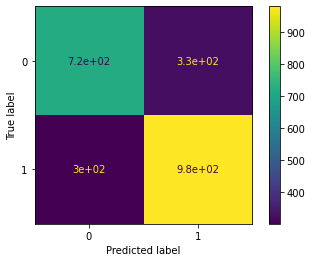

In [290]:
disp = plot_confusion_matrix(clf_rf, X_test, y_test)

In [244]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_depth=5)

In [248]:
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.7392611683848798

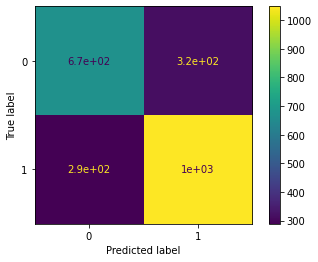

In [230]:
disp = plot_confusion_matrix(clf_dt, X_test, y_test)